# Compare vaccine strains to estimated and observed closest strains to the future

In [1]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from scipy.stats import pearsonr, spearmanr, probplot
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

In [2]:
register_matplotlib_converters()

In [3]:
data_root = "../results/builds/natural/natural_sample_1_with_90_vpm_sliding"
data_root_full_tree = "../results/builds/natural/natural_sample_1_with_90_vpm_sliding_full_tree"
data_root_test = "../results/builds/natural/natural_sample_1_with_90_vpm_sliding_test_tree"
first_validation_timepoint = "2003-10-01"

min_clade_frequency = 0.15
precision = 4
pseudofrequency = 0.001
number_of_bootstrap_samples = 200

In [4]:
mpl.rcParams["figure.figsize"]

[6.0, 4.0]

In [5]:
sns.set_style("white")
plt.style.use("huddlej")

In [6]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18
mpl.rcParams['text.usetex'] = False

## Load data

In [7]:
validation_forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint", "future_timepoint"]
)

In [8]:
validation_forecasts = validation_forecasts.query("timepoint >= '%s'" % first_validation_timepoint).dropna().copy()

In [9]:
test_forecasts = pd.read_csv(
    "%s/forecasts.tsv" % data_root_test,
    sep="\t",
    parse_dates=["timepoint", "future_timepoint"]
).dropna()

In [10]:
test_forecasts.head()

,timepoint,strain,frequency,weighted_distance_to_present,weighted_distance_to_future,fitness,projected_frequency,y,future_timepoint
0,2015-04-01,A/Acre/133946-IEC/2015,0.001147,12.130224,14.651518,-1.405577,9.413472e-05,12.419005,2016-04-01
1,2015-04-01,A/Acre/134221-IEC/2015,0.001917,5.941325,5.578218,1.237355,2.211156e-03,4.174920,2016-04-01
2,2015-04-01,A/Aichi/134/2014,0.000293,7.947723,7.618517,-4.964836,6.843642e-07,6.268473,2016-04-01
3,2015-04-01,A/Aichi/96/2015,0.002101,7.058784,7.029317,0.962468,1.840947e-03,5.597070,2016-04-01
4,2015-04-01,A/Alaska/4032/2014,0.000231,5.059764,4.630501,-0.912599,3.103818e-05,3.277384,2016-04-01


In [11]:
validation_forecasts.tail()

,timepoint,strain,frequency,weighted_distance_to_present,weighted_distance_to_future,fitness,projected_frequency,y,future_timepoint
13832,2014-10-01,A/Yaroslavl/234/2014,0.000023,6.974064,10.856788,-0.956501,0.000003,8.405557,2015-10-01
13833,2014-10-01,A/Yokohama/89/2014,0.003732,8.571176,13.696204,-2.369266,0.000131,9.005099,2015-10-01
13834,2014-10-01,A/Yucatan/18984/2014,0.002778,12.573582,17.981659,-2.433890,0.000092,15.175075,2015-10-01
13835,2014-10-01,A/Yucatan/2660/2014,0.003722,14.234249,8.961054,-3.680626,0.000035,11.151955,2015-10-01
13836,2014-10-01,A/Zambia/6-037/2014,0.000066,6.379110,10.855245,-0.057863,0.000023,7.643570,2015-10-01


In [12]:
forecasts = pd.concat([validation_forecasts, test_forecasts])

In [13]:
forecasts.head()

,timepoint,strain,frequency,weighted_distance_to_present,weighted_distance_to_future,fitness,projected_frequency,y,future_timepoint
1971,2003-10-01,A/Alaska/17/2003,0.000089,16.009253,17.584641,-0.404540,0.000022,15.998975,2004-10-01
1972,2003-10-01,A/Alaska/AK-V03-1257/2003,0.003066,19.602892,19.669335,-0.877438,0.000469,19.903079,2004-10-01
1973,2003-10-01,A/Alaska/AK-V03-708/2003,0.000089,16.009253,17.584641,-0.404540,0.000022,15.998975,2004-10-01
1974,2003-10-01,A/Anhui/318/2003,0.003663,9.363720,7.813836,-2.004048,0.000181,9.102362,2004-10-01
1975,2003-10-01,A/Anhui/467/2003,0.005841,9.795141,8.308792,-2.305196,0.000214,9.271581,2004-10-01


In [14]:
forecasts.shape

(19705, 9)

In [15]:
validation_forecasts.shape

(11866, 9)

In [16]:
test_forecasts.shape

(7839, 9)

In [17]:
validation_forecasts.shape[0] + test_forecasts.shape[0]

19705

In [18]:
forecasts.dropna().shape

(19705, 9)

## Estimated and observed closest strains per timepoint

In [19]:
sorted_df = forecasts.sort_values(
    ["timepoint"]
).copy()

In [20]:
sorted_df.head()

,timepoint,strain,frequency,weighted_distance_to_present,weighted_distance_to_future,fitness,projected_frequency,y,future_timepoint
1971,2003-10-01,A/Alaska/17/2003,0.000089,16.009253,17.584641,-0.404540,0.000022,15.998975,2004-10-01
2257,2003-10-01,A/Queensland/36/2003,0.004201,3.966987,8.435527,1.891504,0.010237,0.940680,2004-10-01
2256,2003-10-01,A/Queensland/34/2003,0.005029,4.926188,9.434368,-0.066184,0.001730,1.928081,2004-10-01
2255,2003-10-01,A/Queensland/33/2003,0.005029,4.689656,8.461929,-0.206193,0.001504,2.571332,2004-10-01
2254,2003-10-01,A/Queensland/32/2003,0.004376,5.765299,10.393585,-0.423270,0.001053,2.907587,2004-10-01


In [21]:
validation_tips_with_sequence = pd.read_csv(
    "%s/tip_attributes_with_weighted_distances.tsv" % data_root,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["strain", "timepoint", "frequency", "aa_sequence"]
)

In [22]:
test_tips_with_sequence = pd.read_csv(
    "%s/tip_attributes_with_weighted_distances.tsv" % data_root_test,
    sep="\t",
    parse_dates=["timepoint"],
    usecols=["strain", "timepoint", "frequency", "aa_sequence"]
)

In [23]:
validation_tips_with_sequence.shape

(15788, 4)

In [24]:
validation_tips_with_sequence = validation_tips_with_sequence[
    validation_tips_with_sequence["timepoint"].isin(validation_forecasts["timepoint"])
].copy()

In [25]:
validation_tips_with_sequence.shape

(11866, 4)

In [26]:
distinct_validation_tips_with_sequence = validation_tips_with_sequence.groupby(["timepoint", "aa_sequence"]).first().reset_index()

In [27]:
distinct_test_tips_with_sequence = test_tips_with_sequence.groupby(["timepoint", "aa_sequence"]).first().reset_index()

In [28]:
distinct_validation_tips_with_sequence.head()

,timepoint,aa_sequence,strain,frequency
0,2003-10-01,MKAIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/HongKong/CUHK50895/2003,0.002181
1,2003-10-01,MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/Hanoi/HN695/2003,0.004433
2,2003-10-01,MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/Dakar/66/2003,0.003903
3,2003-10-01,MKTIIALSYILCLVFAQKLPENDNSTATLCLGHHAVPNGTLVKTIT...,A/Brazil/1609/2003,0.001330
4,2003-10-01,MKTIIALSYILCLVFAQKLPGNDKSTATLCLGHHAVPNGTLVKTIT...,A/Greece/109/2003,0.000038


In [29]:
distinct_validation_tips_with_sequence.tail()

,timepoint,aa_sequence,strain,frequency
5461,2014-10-01,MKTIIALSYIVCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/SouthAfrica/4100/2014,0.000440
5462,2014-10-01,MKTIIALSYTLCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/HongKong/7276/2014,0.002304
5463,2014-10-01,MKTIIALSYVLCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/Nonthaburi/302/2014,0.001053
5464,2014-10-01,MKTIIAVSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/SaoPaulo/6-11780/2014,0.001512
5465,2014-10-01,MKTTIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/FrenchGuiana/9100/2014,0.000035


In [30]:
distinct_test_tips_with_sequence.head()

,timepoint,aa_sequence,strain,frequency
0,2015-04-01,MKAIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/Singapore/GP244/2015,0.001784
1,2015-04-01,MKIIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/Victoria/901/2015,0.001467
2,2015-04-01,MKPIIALSYILCLVFALKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/Thailand/CU-B10952/2014,0.000025
3,2015-04-01,MKTIIALGYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/Tochigi/15112/2015,0.001361
4,2015-04-01,MKTIIALGYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/Japan/4649/2015,0.001318


In [31]:
distinct_test_tips_with_sequence.tail()

,timepoint,aa_sequence,strain,frequency
4330,2019-10-01,MKTVIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/Smolensk/RII-4185S/2019,0.000012
4331,2019-10-01,MMTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/Victoria/67/2019,0.000764
4332,2019-10-01,MQTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/Sydney/404/2019,0.004098
4333,2019-10-01,MRTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/Loei/174/2019,0.000032
4334,2019-10-01,MRTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/Nagano/2410/2019,0.000841


In [32]:
tips_with_sequence = pd.concat([validation_tips_with_sequence, test_tips_with_sequence])

In [33]:
distinct_tips_with_sequence = pd.concat([distinct_validation_tips_with_sequence, distinct_test_tips_with_sequence])

In [34]:
sorted_df = sorted_df.merge(
    distinct_tips_with_sequence,
    on=["timepoint", "strain", "frequency"]
)

In [35]:
sorted_df.head()

,timepoint,strain,frequency,weighted_distance_to_present,weighted_distance_to_future,fitness,projected_frequency,y,future_timepoint,aa_sequence
0,2003-10-01,A/Alaska/17/2003,0.000089,16.009253,17.584641,-0.404540,0.000022,15.998975,2004-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTLVKTIT...
1,2003-10-01,A/Queensland/33/2003,0.005029,4.689656,8.461929,-0.206193,0.001504,2.571332,2004-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...
2,2003-10-01,A/Queensland/32/2003,0.004376,5.765299,10.393585,-0.423270,0.001053,2.907587,2004-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...
3,2003-10-01,A/Queensland/31/2003,0.004318,4.958346,9.435531,1.220590,0.005379,1.929921,2004-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...
4,2003-10-01,A/Pune/38254/2003,0.004875,6.402991,10.400901,-0.766526,0.000833,4.520336,2004-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...


In [36]:
sorted_df.tail()

,timepoint,strain,frequency,weighted_distance_to_present,weighted_distance_to_future,fitness,projected_frequency,y,future_timepoint,aa_sequence
7440,2018-10-01,A/Iceland/95/2018,0.000246,13.231847,16.597814,-2.626290,0.000004,15.491844,2019-10-01,MKTIIALSYILCLVFAQKIPGDDNSTATLCLGHHAVPNGTIVKTIT...
7441,2018-10-01,A/Incheon/1425/2018,0.000213,8.461138,10.091931,-1.507506,0.000011,5.019680,2019-10-01,MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...
7442,2018-10-01,A/India/4661/2018,0.000025,8.393965,9.934707,0.030123,0.000006,4.982965,2019-10-01,MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...
7443,2018-10-01,A/Hubei-Xiling/1276/2018,0.000033,8.849557,10.440846,-1.106401,0.000002,4.772417,2019-10-01,MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...
7444,2018-10-01,A/Zanjan/136944/2018,0.002454,10.700212,13.064759,-2.981737,0.000028,7.405003,2019-10-01,MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...


In [37]:
sorted_df["timepoint_rank"] = sorted_df.groupby("timepoint")["weighted_distance_to_future"].rank(pct=True)
sorted_df["timepoint_estimated_rank"] = sorted_df.groupby("timepoint")["y"].rank(pct=True)

In [38]:
spearmanr(
    sorted_df["timepoint_rank"],
    sorted_df["timepoint_estimated_rank"]
)

SpearmanrResult(correlation=0.8159208930141005, pvalue=0.0)

In [39]:
observed_closest_strains = sorted_df.sort_values(
    ["timepoint", "weighted_distance_to_future"],
    ascending=True
).groupby("timepoint").first().reset_index().loc[:, ["timepoint", "strain", "weighted_distance_to_future", "aa_sequence"]]

In [40]:
estimated_closest_strains = sorted_df.sort_values(
    ["timepoint", "y"],
    ascending=True
).groupby("timepoint").first().reset_index().loc[:, ["timepoint", "strain", "weighted_distance_to_future", "y", "timepoint_rank", "aa_sequence"]]

In [41]:
estimated_closest_strains.head()

,timepoint,strain,weighted_distance_to_future,y,timepoint_rank,aa_sequence
0,2003-10-01,A/Australia/NHRC0001/2003,8.435527,0.940680,0.319018,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...
1,2004-04-01,A/Austria/140489/2004,5.249861,1.365262,0.027027,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...
2,2004-10-01,A/Dakar/18/2004,4.378632,1.145955,0.039735,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...
3,2005-04-01,A/Austria/208387/2005,4.550486,1.518462,0.010811,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...
4,2005-10-01,A/Anhui/1216/2005,3.332189,0.632870,0.005814,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...


In [42]:
closest_strains = observed_closest_strains.merge(
    estimated_closest_strains,
    on=["timepoint"],
    suffixes=["_observed", "_estimated"]
)

In [43]:
closest_strains.head()

,timepoint,strain_observed,weighted_distance_to_future_observed,aa_sequence_observed,strain_estimated,weighted_distance_to_future_estimated,y,timepoint_rank,aa_sequence_estimated
0,2003-10-01,A/Jiangxi/20/2003,4.077711,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/Australia/NHRC0001/2003,8.435527,0.940680,0.319018,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...
1,2004-04-01,A/BacGiang/BG003/2004,4.393321,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/Austria/140489/2004,5.249861,1.365262,0.027027,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...
2,2004-10-01,A/Jeonnam/336/2004,3.317366,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/Dakar/18/2004,4.378632,1.145955,0.039735,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...
3,2005-04-01,A/Chongqing/1096/2005,3.637684,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/Austria/208387/2005,4.550486,1.518462,0.010811,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...
4,2005-10-01,A/Anhui/1216/2005,3.332189,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,A/Anhui/1216/2005,3.332189,0.632870,0.005814,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...


In [44]:
with open("../config/vaccines_h3n2.json", "r") as fh:
    vaccines_json = json.load(fh)

In [45]:
vaccine_df = pd.DataFrame([
    {
        "vaccine_strain": vaccine,
        "vaccine_timepoint": vaccine_data["vaccine"]["timepoint"],
        "aa_sequence": vaccine_data["aa_sequence"]
    }
    for vaccine, vaccine_data in vaccines_json["nodes"].items()
])
vaccine_df["vaccine_timepoint"] = pd.to_datetime(vaccine_df["vaccine_timepoint"])
vaccine_df["future_vaccine_timepoint"] = vaccine_df["vaccine_timepoint"] + pd.DateOffset(months=12)

In [46]:
vaccine_df

,vaccine_strain,vaccine_timepoint,aa_sequence,future_vaccine_timepoint
0,A/Fujian/411/2002,2003-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2004-10-01
1,A/Wellington/1/2004,2004-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2005-10-01
2,A/California/7/2004,2005-04-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2006-04-01
3,A/Wisconsin/67/2005,2006-04-01,MKTIIALSYILCLVFAQKLPGNDDSTATLCLGHHAVPNGTIVKTIT...,2007-04-01
4,A/Brisbane/10/2007,2007-10-01,MKTIIALSYILCLVFTQKLPGNDNSTAXLCLGHHAVPNGTIVKTIT...,2008-10-01
5,A/Perth/16/2009,2009-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2010-10-01
6,A/Victoria/361/2011,2012-04-01,MKTIIALSHILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2013-04-01
7,A/Texas/50/2012,2013-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2014-10-01
8,A/Switzerland/9715293/2013,2014-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2015-10-01
9,A/HongKong/4801/2014,2015-10-01,MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,2016-10-01


In [47]:
forecasts.head()

,timepoint,strain,frequency,weighted_distance_to_present,weighted_distance_to_future,fitness,projected_frequency,y,future_timepoint
1971,2003-10-01,A/Alaska/17/2003,0.000089,16.009253,17.584641,-0.404540,0.000022,15.998975,2004-10-01
1972,2003-10-01,A/Alaska/AK-V03-1257/2003,0.003066,19.602892,19.669335,-0.877438,0.000469,19.903079,2004-10-01
1973,2003-10-01,A/Alaska/AK-V03-708/2003,0.000089,16.009253,17.584641,-0.404540,0.000022,15.998975,2004-10-01
1974,2003-10-01,A/Anhui/318/2003,0.003663,9.363720,7.813836,-2.004048,0.000181,9.102362,2004-10-01
1975,2003-10-01,A/Anhui/467/2003,0.005841,9.795141,8.308792,-2.305196,0.000214,9.271581,2004-10-01


In [48]:
tips_for_vaccines_df = vaccine_df.merge(
    tips_with_sequence,
    left_on=["future_vaccine_timepoint"],
    right_on=["timepoint"],
    suffixes=["_vaccine", ""]
)

In [49]:
tips_for_vaccines_df.head()

,vaccine_strain,vaccine_timepoint,aa_sequence_vaccine,future_vaccine_timepoint,strain,aa_sequence,timepoint,frequency
0,A/Fujian/411/2002,2003-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2004-10-01,A/Aichi/181/2004,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2004-10-01,0.001601
1,A/Fujian/411/2002,2003-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2004-10-01,A/Aichi/183/2004,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2004-10-01,0.005334
2,A/Fujian/411/2002,2003-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2004-10-01,A/Anhui/789/2004,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2004-10-01,0.000037
3,A/Fujian/411/2002,2003-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2004-10-01,A/Aomori/43/2004,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2004-10-01,0.000012
4,A/Fujian/411/2002,2003-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2004-10-01,A/Argentina/126/2004,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2004-10-01,0.000670


In [50]:
def calculate_weighted_distance_between_pairs(row):
    distance = (
        np.frombuffer(row["aa_sequence_vaccine"].encode(), dtype="S1") !=
        np.frombuffer(row["aa_sequence"].encode(), dtype="S1")
    ).sum()
    return row["frequency"] * distance

def calculate_weighted_distance_by_group(group_df):
    return group_df.apply(calculate_weighted_distance_between_pairs, axis=1).sum()

In [51]:
vaccine_distance_to_future = tips_for_vaccines_df.groupby("vaccine_timepoint").apply(
    calculate_weighted_distance_by_group
).reset_index(name="vaccine_distance_to_future")

In [52]:
vaccine_forecasts = vaccine_df.merge(
    vaccine_distance_to_future,
    on="vaccine_timepoint"
)

In [53]:
vaccine_forecasts

,vaccine_strain,vaccine_timepoint,aa_sequence,future_vaccine_timepoint,vaccine_distance_to_future
0,A/Fujian/411/2002,2003-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2004-10-01,9.442527
1,A/Wellington/1/2004,2004-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2005-10-01,6.078590
2,A/California/7/2004,2005-04-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2006-04-01,7.495850
3,A/Wisconsin/67/2005,2006-04-01,MKTIIALSYILCLVFAQKLPGNDDSTATLCLGHHAVPNGTIVKTIT...,2007-04-01,10.304876
4,A/Brisbane/10/2007,2007-10-01,MKTIIALSYILCLVFTQKLPGNDNSTAXLCLGHHAVPNGTIVKTIT...,2008-10-01,5.784087
5,A/Perth/16/2009,2009-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2010-10-01,7.950955
6,A/Victoria/361/2011,2012-04-01,MKTIIALSHILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2013-04-01,6.265836
7,A/Texas/50/2012,2013-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2014-10-01,8.650229
8,A/Switzerland/9715293/2013,2014-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2015-10-01,10.824636
9,A/HongKong/4801/2014,2015-10-01,MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,2016-10-01,6.085611


In [54]:
closest_strains_with_vaccine_timepoints = closest_strains[closest_strains["timepoint"].isin(vaccine_forecasts["vaccine_timepoint"])]

In [55]:
vaccine_forecasts = vaccine_forecasts[vaccine_forecasts["vaccine_timepoint"].isin(closest_strains_with_vaccine_timepoints["timepoint"])].copy()

In [56]:
closest_strains_with_vaccine_timepoints.shape

(12, 9)

In [57]:
vaccine_forecasts.shape

(12, 5)

In [58]:
for index, record in vaccine_forecasts.iterrows():
    print(record["vaccine_strain"])

A/Fujian/411/2002
A/Wellington/1/2004
A/California/7/2004
A/Wisconsin/67/2005
A/Brisbane/10/2007
A/Perth/16/2009
A/Victoria/361/2011
A/Texas/50/2012
A/Switzerland/9715293/2013
A/HongKong/4801/2014
A/Singapore/Infimh-16-0019/2016
A/Switzerland/8060/2017


In [59]:
max_analysis_distance_to_future = closest_strains_with_vaccine_timepoints.loc[
    :, ["weighted_distance_to_future_observed", "weighted_distance_to_future_estimated"]
].max().max()

max_vaccine_distance_to_future = vaccine_forecasts["vaccine_distance_to_future"].max()
max_distance_to_future = max(max_analysis_distance_to_future, max_vaccine_distance_to_future)

In [60]:
distance_ticks = np.arange(int(np.ceil(max_distance_to_future)) + 2, step=2)

In [61]:
distance_ticks

array([ 0,  2,  4,  6,  8, 10, 12, 14, 16])

In [62]:
vaccine_forecasts["vaccine_distance_to_future"].max()

15.165326

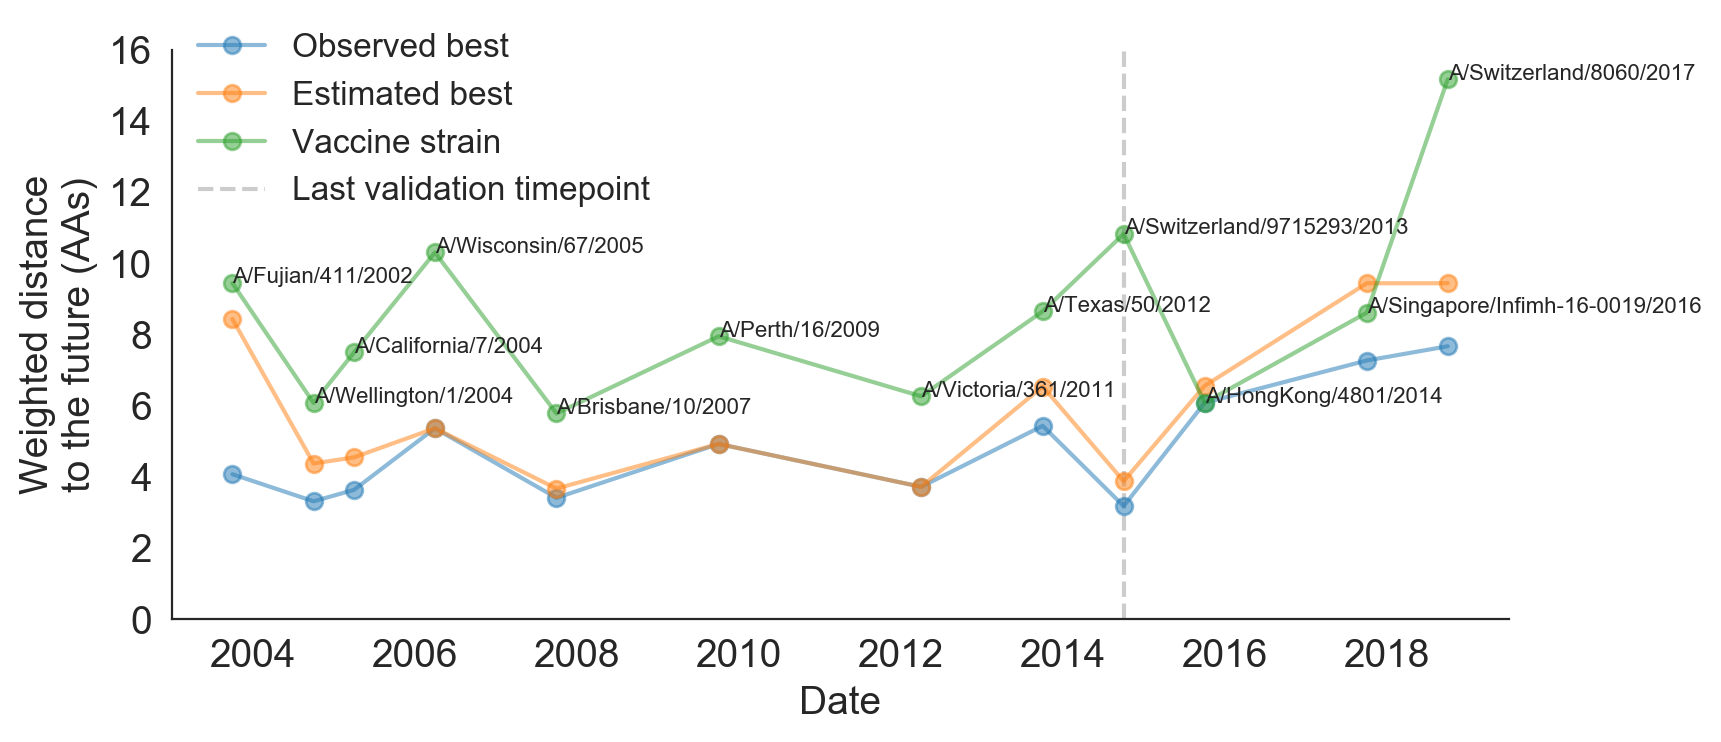

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
strain_alpha=0.5
ax.plot(
    closest_strains_with_vaccine_timepoints["timepoint"],
    closest_strains_with_vaccine_timepoints["weighted_distance_to_future_observed"],
    "o-", label="Observed best", alpha=strain_alpha
)
ax.plot(
    closest_strains_with_vaccine_timepoints["timepoint"],
    closest_strains_with_vaccine_timepoints["weighted_distance_to_future_estimated"],
    "o-", label="Estimated best", alpha=strain_alpha
)
ax.plot(
    vaccine_forecasts["vaccine_timepoint"],
    vaccine_forecasts["vaccine_distance_to_future"],
    "o-", label="Vaccine strain", alpha=strain_alpha
)

for index, record in vaccine_forecasts.iterrows():
    ax.text(
        record["vaccine_timepoint"],
        record["vaccine_distance_to_future"],
        record["vaccine_strain"],
        fontsize=8
    )

ax.axvline(
    validation_forecasts["timepoint"].max(),
    zorder=-10,
    alpha=0.2,
    color="#000000",
    linestyle="--",
    label="Last validation timepoint"
)

ax.legend(
    loc=(0.01, 0.7),
    frameon=False
)

ax.set_yticks(distance_ticks)

ax.set_xlabel("Date")
ax.set_ylabel("Weighted distance\nto the future (AAs)")
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig("../manuscript/figures/vaccine-comparison.png", bbox_inches="tight")

In [64]:
vaccine_forecasts

,vaccine_strain,vaccine_timepoint,aa_sequence,future_vaccine_timepoint,vaccine_distance_to_future
0,A/Fujian/411/2002,2003-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2004-10-01,9.442527
1,A/Wellington/1/2004,2004-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2005-10-01,6.078590
2,A/California/7/2004,2005-04-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2006-04-01,7.495850
3,A/Wisconsin/67/2005,2006-04-01,MKTIIALSYILCLVFAQKLPGNDDSTATLCLGHHAVPNGTIVKTIT...,2007-04-01,10.304876
4,A/Brisbane/10/2007,2007-10-01,MKTIIALSYILCLVFTQKLPGNDNSTAXLCLGHHAVPNGTIVKTIT...,2008-10-01,5.784087
5,A/Perth/16/2009,2009-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2010-10-01,7.950955
6,A/Victoria/361/2011,2012-04-01,MKTIIALSHILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2013-04-01,6.265836
7,A/Texas/50/2012,2013-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2014-10-01,8.650229
8,A/Switzerland/9715293/2013,2014-10-01,MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNGTIVKTIT...,2015-10-01,10.824636
9,A/HongKong/4801/2014,2015-10-01,MKTIIALSYILCLVFAQKIPGNDNSTATLCLGHHAVPNGTIVKTIT...,2016-10-01,6.085611


In [67]:
merged_model_and_vaccine_df = closest_strains_with_vaccine_timepoints.merge(
    vaccine_forecasts,
    left_on=["timepoint"],
    right_on=["vaccine_timepoint"]
)

In [75]:
merged_model_and_vaccine_df["vaccine_distance_to_future"] - merged_model_and_vaccine_df["weighted_distance_to_future_estimated"]

0     1.007000
1     1.699958
2     2.945364
3     4.936734
4     2.109116
5     3.022489
6     2.541889
7     2.110323
8     6.942614
9    -0.473553
10   -0.825778
11    5.724443
dtype: float64